In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
df = pd.read_csv('apps_policy.csv')

In [42]:
df.shape

(22556, 31)

### Create buckets

In [43]:
## Create GLA buckets
def f(df):
    if df['gla'] < 75000:
        val = 'a. < 75k'
    elif df['gla'] < 250000:
        val = 'b. 75k - 250k'
    elif df['gla'] < 500000:
        val = 'c. 250k - 500k'
    elif df['gla'] < 1000000:
        val = 'd. 500k - 1M'
    elif df['gla'] >= 1000000:
        val = 'e. 1M+'
    else: val = 'error'
    return val

df['gla_buckets'] = df.apply(f, axis = 1)

## Create inflow buckets
def i(df):
    if df['avg_3_month_revenue'] == '':
        val = 'none'
    elif df['avg_3_month_revenue'] < 10000:
        val = 'a. 0 - 10k'
    elif df['avg_3_month_revenue'] < 25000:
        val = 'b. 10k - 25k'
    elif df['avg_3_month_revenue'] < 50000:
        val = 'c. 25k - 50k'
    elif df['avg_3_month_revenue'] < 100000:
        val = 'd. 50k - 100k'
    elif df['avg_3_month_revenue'] < 500000:
        val = 'e. 100k - 500k'
    elif df['avg_3_month_revenue'] > 500000:
        val = 'f. 500k+'
    else: val = 'error'
    return val

df['inflow_buckets'] = df.apply(i, axis = 1)

## Filter down to only submitted apps in September + exclude non-standard policy + exclude fraud rejection reasons

In [44]:
##Additional fields
df['Date'] = pd.to_datetime(df.fa_submitted_at).dt.strftime('%Y-%m-%d')
df['approved_limit'] = df['gla'] *0.1

## get only Sept submissions
new_df = df.loc[(df['fa_status'] != 'Pending') & (df['fa_status'] != '') & (df['Date'] >= '2021-09-01') & (df['Date'] <= '2021-09-30') & ((df['business_policy_type'] == 'STANDARD_POLICY') | (df['business_policy_type'].isnull()) & (df['fa_rejection_reason'] != 'Suspected fraud'))]

new_df.shape

(1327, 35)

## SBFE score distribution

(array([  4.,  13.,  32.,  60., 143., 384., 129., 115.,  71.,  17.]),
 array([760. , 781.9, 803.8, 825.7, 847.6, 869.5, 891.4, 913.3, 935.2,
        957.1, 979. ]),
 <BarContainer object of 10 artists>)

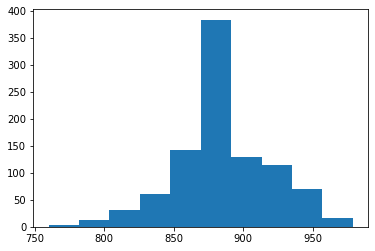

In [45]:
plot_sbfe = new_df.loc[(new_df['sbfe_score'] != '') & (new_df['sbfe_score'] != 0) & (new_df['is_confirmed'] == True)]
plt.hist(plot_sbfe['sbfe_score'], bins = 10)

In [46]:
##What is the mean SBFE score from apps we approve in 75k to 250k GLA bucket
plot_sbfe.loc[(plot_sbfe['fa_status'] == 'Admin Approved') & (new_df['gla'] > 75000) & (new_df['gla'] < 250000)]['sbfe_score'].describe()

count     64.000000
mean     909.687500
std       27.940342
min      859.000000
25%      882.500000
50%      908.500000
75%      932.500000
max      967.000000
Name: sbfe_score, dtype: float64

### Filter down to only those that were Rejected and GLA > 75K, < 250K

(array([ 1.,  3.,  6.,  8., 24., 22.,  9., 10.,  4.,  1.]),
 array([779. , 797.4, 815.8, 834.2, 852.6, 871. , 889.4, 907.8, 926.2,
        944.6, 963. ]),
 <BarContainer object of 10 artists>)

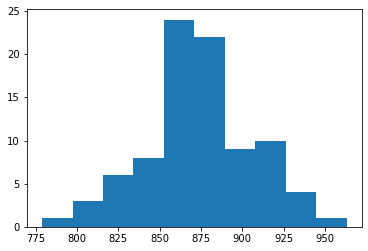

In [47]:
plot_sbfe_rejected = plot_sbfe.loc[((new_df['fa_status'] == 'Rejected') | (new_df['fa_status'] == 'Withdrawn')) & (new_df['gla'] > 75000) & (new_df['gla'] < 250000)]
plt.hist(plot_sbfe_rejected['sbfe_score'], bins = 10)

In [48]:
##What is the mean SBFE score from apps we reject
plot_sbfe_rejected['sbfe_score'].describe()

count     88.000000
mean     874.375000
std       33.021871
min      779.000000
25%      855.750000
50%      876.000000
75%      894.000000
max      963.000000
Name: sbfe_score, dtype: float64

In [49]:
plot_sbfe_rejected.shape

(89, 35)

## Comp Spend distribution

### < 100k competitor spend

(array([372.,  63.,  27.,  21.,   7.,  11.,   6.,   4.,   4.,   5.]),
 array([3.33333333e-03, 9.06603167e+03, 1.81320600e+04, 2.71980883e+04,
        3.62641167e+04, 4.53301450e+04, 5.43961733e+04, 6.34622017e+04,
        7.25282300e+04, 8.15942583e+04, 9.06602867e+04]),
 <BarContainer object of 10 artists>)

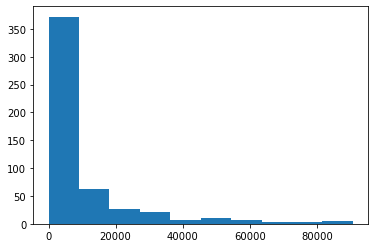

In [50]:
plot_competitor_spend = new_df.loc[(new_df['competitor_avg_3_month_spend'] != '') & (new_df['competitor_avg_3_month_spend'] > 0) & (new_df['competitor_avg_3_month_spend'] < 100000)]
plt.hist(plot_competitor_spend['competitor_avg_3_month_spend'], bins = 10)

In [51]:
plot_competitor_spend.shape

(520, 35)

### < 10k competitor spend

(array([160.,  55.,  39.,  32.,  18.,  24.,  17.,  11.,  13.,  13.]),
 array([3.33333333e-03, 9.94336500e+02, 1.98866967e+03, 2.98300283e+03,
        3.97733600e+03, 4.97166917e+03, 5.96600233e+03, 6.96033550e+03,
        7.95466867e+03, 8.94900183e+03, 9.94333500e+03]),
 <BarContainer object of 10 artists>)

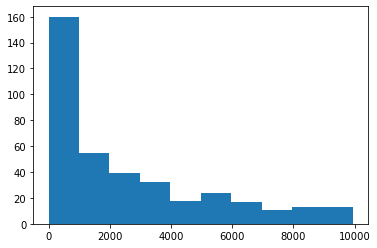

In [52]:
plot_competitor_spend = new_df.loc[(new_df['competitor_avg_3_month_spend'] != '') & (new_df['competitor_avg_3_month_spend'] > 0) & (new_df['competitor_avg_3_month_spend'] < 10000)]
plt.hist(plot_competitor_spend['competitor_avg_3_month_spend'], bins = 10)

In [53]:
plot_competitor_spend.shape

(382, 35)

## 1) Approve Applications with Lower SBFE scores + Use Competitor Spend

In [135]:
submitted = new_df.loc[(df['fa_status'] != 'Pending') & (df['fa_status'] != '') & (df['fa_rejection_reason'] != 'Suspected fraud')]

## approved applications
approved_sbfe = submitted.loc[(submitted['fa_status'] == 'Admin Approved') & (submitted['sbfe_score'].notnull())]
approved_sbfe[['gla_buckets', 'sbfe_score']].groupby('gla_buckets').describe()

sbfe_score                                               \
                    count        mean        std    min     25%    50%   
gla_buckets                                                              
a. < 75k              8.0  890.875000  17.430986  875.0  876.75  889.0   
b. 75k - 250k        65.0  909.353846  27.851409  859.0  883.00  908.0   
c. 250k - 500k       45.0  902.266667  34.639966  820.0  875.00  904.0   
d. 500k - 1M         55.0  898.090909  35.464261  803.0  875.00  902.0   
e. 1M+              134.0  889.567164  33.384173  813.0  870.25  882.5   

                               
                   75%    max  
gla_buckets                    
a. < 75k        894.00  927.0  
b. 75k - 250k   931.00  967.0  
c. 250k - 500k  928.00  962.0  
d. 500k - 1M    927.00  960.0  
e. 1M+          909.75  979.0

In [136]:
approved_sbfe['sbfe_score'].describe()

count    307.000000
mean     897.179153
std       33.315738
min      803.000000
25%      875.000000
50%      894.000000
75%      924.000000
max      979.000000
Name: sbfe_score, dtype: float64

(array([ 8.,  4., 11., 39., 87., 44., 44., 38., 27.,  5.]),
 array([803. , 820.6, 838.2, 855.8, 873.4, 891. , 908.6, 926.2, 943.8,
        961.4, 979. ]),
 <BarContainer object of 10 artists>)

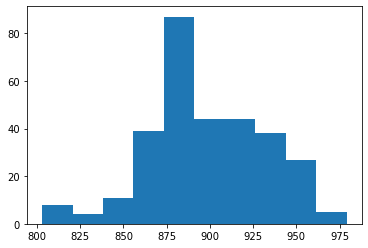

In [137]:
plt.hist(approved_sbfe['sbfe_score'], bins = 10)

- Looks like overall the SBFE score is skewed towards the higher end, which makes sense considering we only approve 880+ in the GLA > 75K, < 250K world

### If we choose to reduce the threshold, what would be the incremental approval?

In [138]:
rejected_sbfe = submitted.loc[((submitted['fa_status'] == 'Rejected') | (submitted['fa_status'] == 'Withdrawn')) & (submitted['sbfe_score'].notnull())]
rejected_sbfe.shape

(621, 35)

In [139]:
rejected_sbfe[['gla_buckets', 'sbfe_score']].groupby('gla_buckets').describe()

sbfe_score                                               \
                    count        mean        std    min     25%    50%   
gla_buckets                                                              
a. < 75k            511.0  874.962818  64.263494    0.0  867.00  877.0   
b. 75k - 250k        90.0  874.622222  32.728223  779.0  856.75  876.0   
c. 250k - 500k        2.0  850.500000  36.062446  825.0  837.75  850.5   
e. 1M+                4.0  864.750000  18.909874  839.0  858.50  868.0   
error                14.0  876.357143  27.051538  815.0  872.00  877.5   

                               
                   75%    max  
gla_buckets                    
a. < 75k        889.00  973.0  
b. 75k - 250k   894.00  963.0  
c. 250k - 500k  863.25  876.0  
e. 1M+          874.25  884.0  
error           886.25  920.0

### Total Incremental Approvals


In [149]:
## Total Incremental Approvals
incremental_approvals = rejected_sbfe.loc[((rejected_sbfe['competitor_avg_3_month_spend'] >= 10000) | (rejected_sbfe['bureau_max_credit_limit'] >= 10000)) 
                                          & (rejected_sbfe['gla'] >= 75000) & (rejected_sbfe['sbfe_score'] >= 860) & ((rejected_sbfe['dpd_30_balance']< 1000) | (rejected_sbfe['dpd_30_balance'].isnull()))]
incremental_approvals[['fa_id','fa_status', 'sbfe_score', 'bureau_max_credit_limit', 'competitor_avg_3_month_spend', 'gla', 'dpd_30_balance', 'is_confirmed', 'estimated_spend']]
incremental_approvals.shape

(14, 35)

#### Only 860-880 approvals

In [169]:
## Lets break this out
## Only 860-880 approvals
inc_860_880 = incremental_approvals[['fa_id','fa_status', 'sbfe_score', 'bureau_max_credit_limit', 'competitor_avg_3_month_spend', 'gla', 'dpd_30_balance', 'is_confirmed', 'estimated_spend', 'fa_rejection_reason']].loc[incremental_approvals['sbfe_score']< 880]
inc_860_880.shape

(5, 10)

In [166]:
##inc_860_880

#### 880+ incrementals

In [171]:
## 880+ incrementals
cond = ((incremental_approvals['fa_rejection_reason'] == 'GLA is below the threshold for the segment'))
inc_880_plus = incremental_approvals[['fa_id','fa_status', 'sbfe_score', 'bureau_max_credit_limit', 'competitor_avg_3_month_spend', 'gla', 'dpd_30_balance', 'is_confirmed', 'estimated_spend', 'fa_rejection_reason']].loc[(incremental_approvals['sbfe_score']>= 880)]
inc_880_plus.shape

(9, 10)

In [160]:
## Filter down to only GLA is below threshold
# cond = ((incremental_approvals['fa_rejection_reason'] == 'GLA is below the threshold for the segment'))
# inc_880_plus.loc[cond].shape
# inc_880_plus.loc[cond]

#### Competitor spend incrementals

In [161]:
## Competitor spend incrementals
comp_spend = incremental_approvals[['fa_id','fa_status', 'sbfe_score', 'bureau_max_credit_limit', 'competitor_avg_3_month_spend', 'gla', 'dpd_30_balance', 'is_confirmed', 'estimated_spend', 'fa_rejection_reason']].loc[(incremental_approvals['sbfe_score']>= 860)
& (((incremental_approvals['bureau_max_credit_limit'].isnull()) | (incremental_approvals['bureau_max_credit_limit'] < 10000)) & (incremental_approvals['competitor_avg_3_month_spend'] >= 10000))]
comp_spend.shape

(8, 10)

In [158]:
comp_spend

,fa_id,fa_status,sbfe_score,bureau_max_credit_limit,competitor_avg_3_month_spend,gla,dpd_30_balance,is_confirmed,estimated_spend,fa_rejection_reason
15725,23084,Rejected,884.0,NaN,22960.566667,75434.63,NaN,True,150000.0,GLA is below the threshold for the segment
15753,21267,Rejected,865.0,NaN,26819.803333,1850920.18,NaN,True,30000.0,Is in a restricted business category
15765,23882,Rejected,867.0,NaN,47998.680000,124483.51,NaN,True,150000.0,GLA is below the threshold for the segment
15977,21302,Rejected,884.0,NaN,227611.666667,1083596.56,NaN,True,400000.0,Incomplete application information
16965,22162,Rejected,919.0,0.0,11111.553333,78622.19,0.0,True,30000.0,GLA is below the threshold for the segment
19735,21522,Rejected,928.0,6000.0,121363.093333,159522.69,0.0,True,150000.0,High debt-to-GLA
20652,22918,Rejected,932.0,1000.0,109109.813333,133691.82,0.0,True,150000.0,GLA is below the threshold for the segment
22549,22105,Rejected,874.0,NaN,14739.036667,83515.99,0.0,True,150000.0,GLA is below the threshold for the segment


### How do we feel about these numbers?

- This means that if we reduce the threshold to 860-880 and implement the competitor spend into policy, we will get an additional 14 businesses
- If we break it down, we are getting: 1) 5 due to competitor spend only, 2) 3 due to both competitor spend and the 860-880 reduction, and 4) 2 due to the 860-880 reduction only. Note the remaining 4 were exceptions where we chose not to approve them either due to WD, GLA, NSFs or overdrafts
- So this is a total of 14/1,431, that is close to 1%
- Or 14/470 , that is close to 3% incremental approval rate. Pretty good - for context, the entire bureau initiative was anchored on 9% incremental approval

#### So how do we decide if this is a good idea?

- Model out expected spend / gain vs expected losses and determine profitability

## 2) Scorecard Approvals in Lower GLA Buckets

In [175]:
scorecard_app = new_df.loc[(new_df['gla'] > 75000) & (new_df['gla'] < 250000) & (new_df['fa_status'].isin(['Admin Approved', 'Rejected', 'Withdrawn']))]
scorecard_app[['fa_status', 'bureau_approved']].value_counts()

fa_status       bureau_approved
Rejected        0                  122
Admin Approved  0                   42
                1                   37
Withdrawn       0                    3
Rejected        1                    3
Withdrawn       1                    1
dtype: int64


- Our world is the 131 rejected + WD + the 42 approved to an extent (althought those are already approved today probably on exception, we would bring them "into policy")

In [56]:
## Incremental Approvals if we just begin using scorecard to approve these
scorecard_app_world = scorecard_app.loc[((scorecard_app['fa_status'].isin(['Rejected', 'Withdrawn'])) | ((scorecard_app['fa_status'] == 'Admin Approved') & (scorecard_app['bureau_approved'] == 0)))]
scorecard_app_world[['scorecard_approved', 'manual_connection_score']].value_counts()

scorecard_approved  manual_connection_score
True                0.0                        83
                    3.0                        53
False               0.0                        29
                    3.0                         6
dtype: int64

- So lets be clear here -> the manual_connection_score = 3 indicates a manual bank connection, meaning the the scorecard_approved tag being = True is not necessarily accurate. 
- This is depicting a "straight decline" where we likely did not manually review the bank statements because there was no bureau record
- Hence, the 53 value we need to tone it down a little, because inside that pocket, there would likely be some that pass policy and others that do not
- If we apply a straight line approval rate of 30% (close to our current approval rate in this world), then 53*0.3 = 16 apps

This leaves us with a total population in Sept of **100 apps that would have been incrementally approved** had we just used scorecard to approve in these buckets

In [57]:
## Average risk segment and score
scorecard_app_world.loc[scorecard_app_world['scorecard_approved'] == 1][['risk_segment', 'risk_score']].describe()

,risk_segment,risk_score
count,136.000000,136.000000
mean,2.191176,2.514706
std,0.638455,2.007339
min,1.000000,0.000000
25%,2.000000,0.000000
50%,2.000000,3.000000
75%,3.000000,3.000000
max,3.000000,9.000000


So the average risk_segment is slightly above 2 and the average risk score < 5, so that gives us an average limit of 10% that would be suggested by the scorecard

In [58]:
## Expected spend from these applications
scorecard_app_world.loc[scorecard_app_world['scorecard_approved'] == 1][['estimated_spend', 'gla', 'approved_limit']].describe()

,estimated_spend,gla,approved_limit
count,136.000000,136.000000,136.000000
mean,31602.308824,132602.951324,13260.295132
std,41540.313821,50776.844235,5077.684424
min,1200.000000,75000.640000,7500.064000
25%,10000.000000,89513.180000,8951.318000
50%,12562.500000,116956.500000,11695.650000
75%,30000.000000,169064.247500,16906.424750
max,150000.000000,249969.000000,24996.900000


Looks like the **mean estimated spend** is 32k whereas the **mean approved_limit** is 13k.
- Lets say that the average application spends somewhere in between, so 25k * 100 applications = 2.5M in expected incremental monthly spend

#### What does this mean in terms of loss rates?
- This means on 2.5M of incremental monthly spend we are making ~10k per month (2.5M * 40bps of profit)
- So, **for this population to support itself**, we can take, well 40bps of losses on the $ volume, which is < 1DQ per month (not so good)
- Given GS covenants, **60% of this population** would have to go almost entirely delinquent to have an impact on a monthly spend volume: 200M * 75bps = 1.5M -> 60%
- This should be projected further

#### What would the world look like we only approve apps with lower risk scores?

In [59]:
scorecard_app_world.loc[scorecard_app_world['scorecard_approved'] == 1]['risk_score'].value_counts()

3.0    81
0.0    40
6.0    12
9.0     3
Name: risk_score, dtype: int64

41 incremental approvals on 0 score, 84 (81-53*0.7+40 - manual conneciotn score) on a risk score of 3 or below

#### What if we bring inflows into the picture?

- unfortunately mostly nulls

In [60]:
scorecard_app_world.loc[scorecard_app_world['scorecard_approved'] == 1][['connection_type','inflow_buckets']].value_counts()

connection_type    inflow_buckets
Manual Connection  error             54
Direct Connection  d. 50k - 100k     18
                   c. 25k - 50k      17
                   e. 100k - 500k    14
                   error             11
                   b. 10k - 25k       7
                   a. 0 - 10k         7
                   f. 500k+           3
Manual Connection  b. 10k - 25k       2
                   a. 0 - 10k         2
                   d. 50k - 100k      1
dtype: int64

#### Is the incremental spend worth the servicing costs?

- This is a discussion to be had and we can build a model

### Results

**Incremental Approvals**
- If we choose to straight approve based on scorecard, we can expect to approve 100 incremental apps per month if we take September as proxy
- If we narrow down to only apps with risk_score <= 3, we can expect to approve 85 businesses

**Estimated Spend** 
- We can expect it to be close to 25k per month on average in this population, which means total profit of ~10k at 100 customers on 40bps of profits - **is this worth it?**
- For the population to support itslef, we can have <1DQ per month. How should we think of this? How can we estimate DQ? Sensitivity

**Open Questions**
- How do we take into account servicing cost of these incremental businesses vs the expected profit?

## 3) Inflow vs Outflow Policy

In [61]:
submitted = df.loc[(df['fa_status'] != 'Pending') & (df['fa_status'] != '') & (df['fa_rejection_reason'] != 'Suspected fraud')]
inflow_apps = submitted.loc[(submitted['avg_3_month_revenue'].notnull()) & (submitted['gla_buckets'] != 'error')]
inflow_apps[['gla', 'avg_3_month_revenue', 'competitor_avg_3_month_spend', 'thirty_day_card_spend']]

,gla,avg_3_month_revenue,competitor_avg_3_month_spend,thirty_day_card_spend
1,2669196.82,3.239558e+05,30663.466667,80.00
2,50037.50,5.003911e+04,NaN,2239.85
26,1813472.71,5.426823e+04,2718.380000,25447.25
41,1470424.42,1.884089e+06,89150.146667,31816.35
75,312818.91,6.244707e+04,2790.183333,8010.45
...,...,...,...,...
22549,83515.99,1.848067e+04,14739.036667,NaN
22550,48.53,3.725865e+03,536.835000,NaN
22551,156.88,1.739553e+03,NaN,NaN
22552,-1019.36,1.645762e+05,63187.273333,NaN


In [62]:
# inflow_apps = submitted.loc[(submitted['avg_3_month_revenue'].notnull()) & (submitted['gla_buckets'] != 'error')]
# inflow_apps[['gla_buckets','inflow_buckets']].value_counts()

#### Thirty Day Spend vs Inflows

(596, 35)

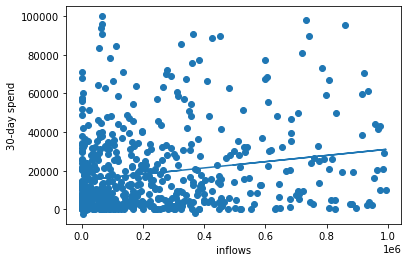

In [63]:
cond_0 = inflow_apps['avg_3_month_revenue'] < 1000000
cond_1 = inflow_apps['fa_status'] == 'Admin Approved'
cond_2 = inflow_apps['thirty_day_card_spend'] < 100000
cond_3 = inflow_apps['tenure'] >= 3

x = inflow_apps.loc[(cond_0) & (cond_1) & (cond_2) & (cond_3)]['avg_3_month_revenue']
y = inflow_apps.loc[(cond_0) & (cond_1) & (cond_2) & (cond_3)]['thirty_day_card_spend']
plt.scatter(x, y)
plt.xlabel('inflows')
plt.ylabel('30-day spend')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

inflow_apps.loc[(cond_0) & (cond_1) & (cond_2) & (cond_3)].shape

####  Competitor Spend vs Inflows

(753, 35)

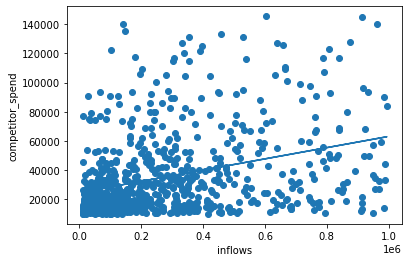

In [64]:
cond = inflow_apps['competitor_avg_3_month_spend'] < 150000
cond_1 = inflow_apps['competitor_avg_3_month_spend'] > 10000
cond_2 = inflow_apps['avg_3_month_revenue'] > 10000
x = inflow_apps.loc[(inflow_apps['avg_3_month_revenue'] < 1000000) & (inflow_apps['competitor_avg_3_month_spend'].notnull() & (cond) & (cond_1) & (cond_2))]['avg_3_month_revenue']
y = inflow_apps.loc[(inflow_apps['avg_3_month_revenue'] < 1000000) & (inflow_apps['competitor_avg_3_month_spend'].notnull() & (cond) & (cond_1) & (cond_2))]['competitor_avg_3_month_spend']
plt.scatter(x, y)
plt.xlabel('inflows')
plt.ylabel('competitor_spend')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

inflow_apps.loc[(inflow_apps['avg_3_month_revenue'] < 1000000) & (inflow_apps['competitor_avg_3_month_spend'].notnull() & (cond) & (cond_1) & (cond_2))].shape

#### GLA vs Inflows

(2030, 35)

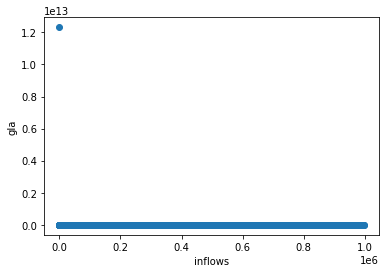

In [65]:
cond = inflow_apps['gla'] > 75000
x = inflow_apps.loc[(inflow_apps['avg_3_month_revenue'] < 1000000) & (cond)]['avg_3_month_revenue']
y = inflow_apps.loc[(inflow_apps['avg_3_month_revenue'] < 1000000) & (cond)]['gla']
plt.scatter(x, y)
plt.xlabel('inflows')
plt.ylabel('gla')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

inflow_apps.loc[(inflow_apps['avg_3_month_revenue'] < 1000000) & (cond)].shape

### Lets looks at only apps in the 75k - 250k GLA range

In [66]:
cond = submitted['gla_buckets'] == 'b. 75k - 250k'
cond_1 = (submitted['avg_3_month_revenue'].notnull())
cond_2 = inflow_apps['fa_status'] == 'Admin Approved'
cond_3 = inflow_apps['fa_status'].isin(['Rejected', 'Withdrawn'])

## Approved and Rejected frames
approved_apps = submitted.loc[(cond) & (cond_1) & (cond_2)]
rejected_apps = submitted.loc[(cond) & (cond_1) & (cond_3)]

In [67]:
plot = rejected_apps[['gla', 'avg_3_month_revenue', 'competitor_avg_3_month_spend']].loc[(rejected_apps['competitor_avg_3_month_spend'].notnull()) 
                                                                                         & (rejected_apps['avg_3_month_revenue'] > 0) 
                                                                                         & (rejected_apps['avg_3_month_revenue'] < 100000)
                                                                                        & (rejected_apps['competitor_avg_3_month_spend'] < 20000)]
plot.shape

(147, 3)

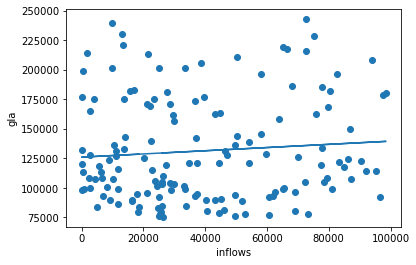

In [68]:
x = plot['avg_3_month_revenue']
y = plot['gla']
z = plot['competitor_avg_3_month_spend']

plt.xlabel('inflows')
plt.ylabel('gla')

plt.scatter(x,y)

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

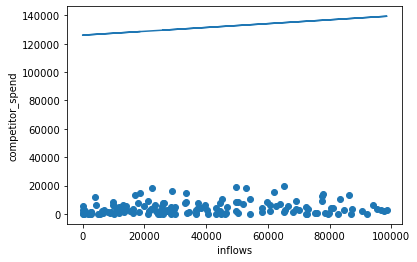

In [69]:
x = plot['avg_3_month_revenue']
y = plot['gla']
z = plot['competitor_avg_3_month_spend']

plt.xlabel('inflows')
plt.ylabel('competitor_spend')

plt.scatter(x,z)

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

In [70]:
approved_apps.shape

(259, 35)

(132, 35)

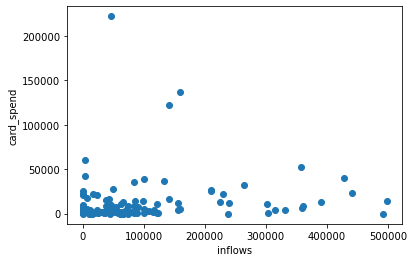

In [71]:
plot = approved_apps.loc[(approved_apps['avg_3_month_revenue']< 500000) & approved_apps['tenure'] >= 1]

y = plot['thirty_day_card_spend']
x = plot['avg_3_month_revenue']
plt.scatter(x,y)
plt.xlabel('inflows')
plt.ylabel('card_spend')

plot.shape